# Time Series Clustering

### Inspired by https://www.kaggle.com/code/izzettunc/introduction-to-time-series-clustering#3.-Libraries

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
from tslearn.clustering import TimeSeriesKMeans
import numpy as np

## Load data

In [2]:
data = pd.read_csv('../data/devices1.csv')

In [3]:
data.head()

,battery_voltage,current,current_in,current_out,panel_voltage,state_of_charge_percent,temperature,timestamp,usb_current,voltage,battery_id
0,7.090,-2.542,2.544,0.002,7.240,NaN,NaN,2021-03-02 06:33:24,0.002,7.185,0
1,7.100,-2.548,2.550,0.002,7.245,NaN,NaN,2021-03-02 06:35:24,0.002,7.190,0
2,7.095,-2.472,2.474,0.002,7.275,NaN,NaN,2021-03-02 06:37:24,0.002,7.215,0
3,7.070,-2.232,2.236,0.004,7.370,NaN,NaN,2021-03-02 06:39:24,0.002,7.290,0
4,7.075,-2.276,2.278,0.002,7.350,100.0,28.287938,2021-03-02 06:41:24,0.002,7.280,0


## Inputs

In [4]:
variable_to_analyse = "battery_voltage"
frequency = "weekly"  # Either daily, weekly, monthly or seasonally

## Battery Voltage Analysis

### Preprocessing

#### Data preparation

In [5]:
# Converting data timestamp in datetime objects
data.timestamp = pd.to_datetime(data.timestamp)

# Keeping only studied variables
data = data[["timestamp", variable_to_analyse, "battery_id"]]

# Setting date column as index
data.set_index("timestamp", inplace=True)

#### Selecting time frame

In [6]:
# TODO selecting specific time intervals
begin_dt = "2021-05-02 00:00:00"
end_dt = "2021-05-08 23:59:59"

# Selecting study time intervals
data = data.loc[(data.index > pd.Timestamp(begin_dt)) & (data.index < pd.Timestamp(end_dt))]

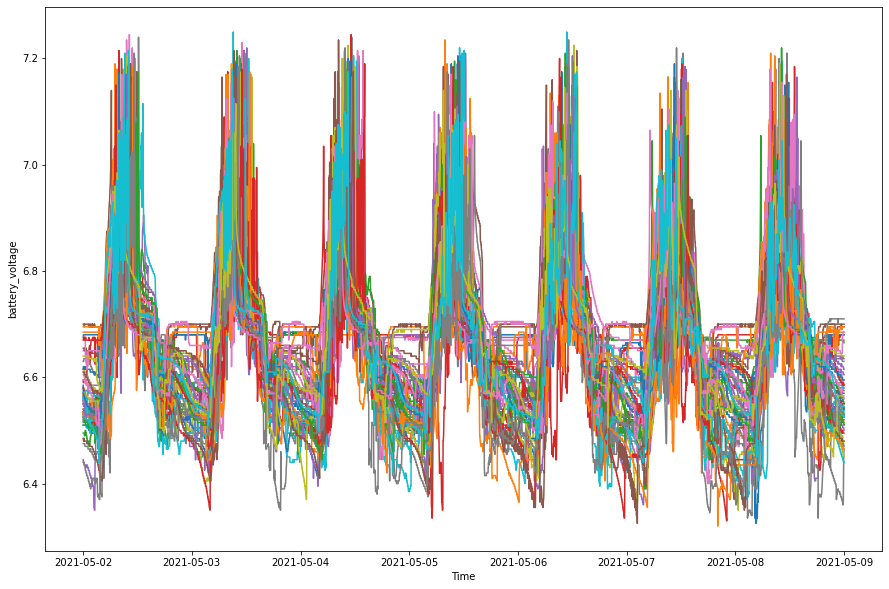

In [7]:
bat_df = []  # List to store every battery dataframe

# Larger plots showing inline
plt.rcParams["figure.figsize"] = (15,10)

for i in range(len(data.battery_id.unique())):
    bat_df.append(data.loc[data.battery_id == i][variable_to_analyse])  # Storing specific battery id dataframe
    plt.plot(bat_df[i])

plt.ylabel(variable_to_analyse)
plt.xlabel("Time")
plt.show()

#### Standardizing size

##### Finding longest time series

In [8]:
series_lengths = {len(series) for series in bat_df}  # Serie length of every battery dataframe
max_len = max(series_lengths)  # max lenght amongst all series
longest_series = None

for series in bat_df:
    if len(series) == max_len:
        longest_series = series

##### Normalizing size

In [9]:
problems_index = []  # Finding battery indexes that need to be re-indexed to the longest time serie

for i in range(len(bat_df)):
    # Time series that aren't as long as the largest one need to be reindexed
    if len(bat_df[i]) != max_len:
        problems_index.append(i)
        # Values are reindexed to the nearest (1 min tolerance) time index of the longest time serie
        bat_df[i] = bat_df[i].reindex(index=longest_series.index, method='nearest', tolerance='1min')

##### Dealing with NaN values

In [10]:
# Values who couldn't be reindexed or gaps are filled using interpolation
for i in problems_index:
    bat_df[i].interpolate(limit_direction="both", inplace=True)

##### Scaling

In [11]:
#TODO ?

### K-means clustering

#### Choosing number of clusters

In [12]:
# Rule of thumb : choosing k as the square root of the number of points
# cluster_count = math.ceil(math.sqrt(len(bat_df)))
cluster_count = 6

#### Fit k-means clustering

In [13]:
# Time series specific clustering algorithm
km = TimeSeriesKMeans(n_clusters=cluster_count, metric="euclidean")  # dtw metric takes way too long...

# Predict closest cluster for each time series
labels = km.fit_predict(bat_df)

##### Results

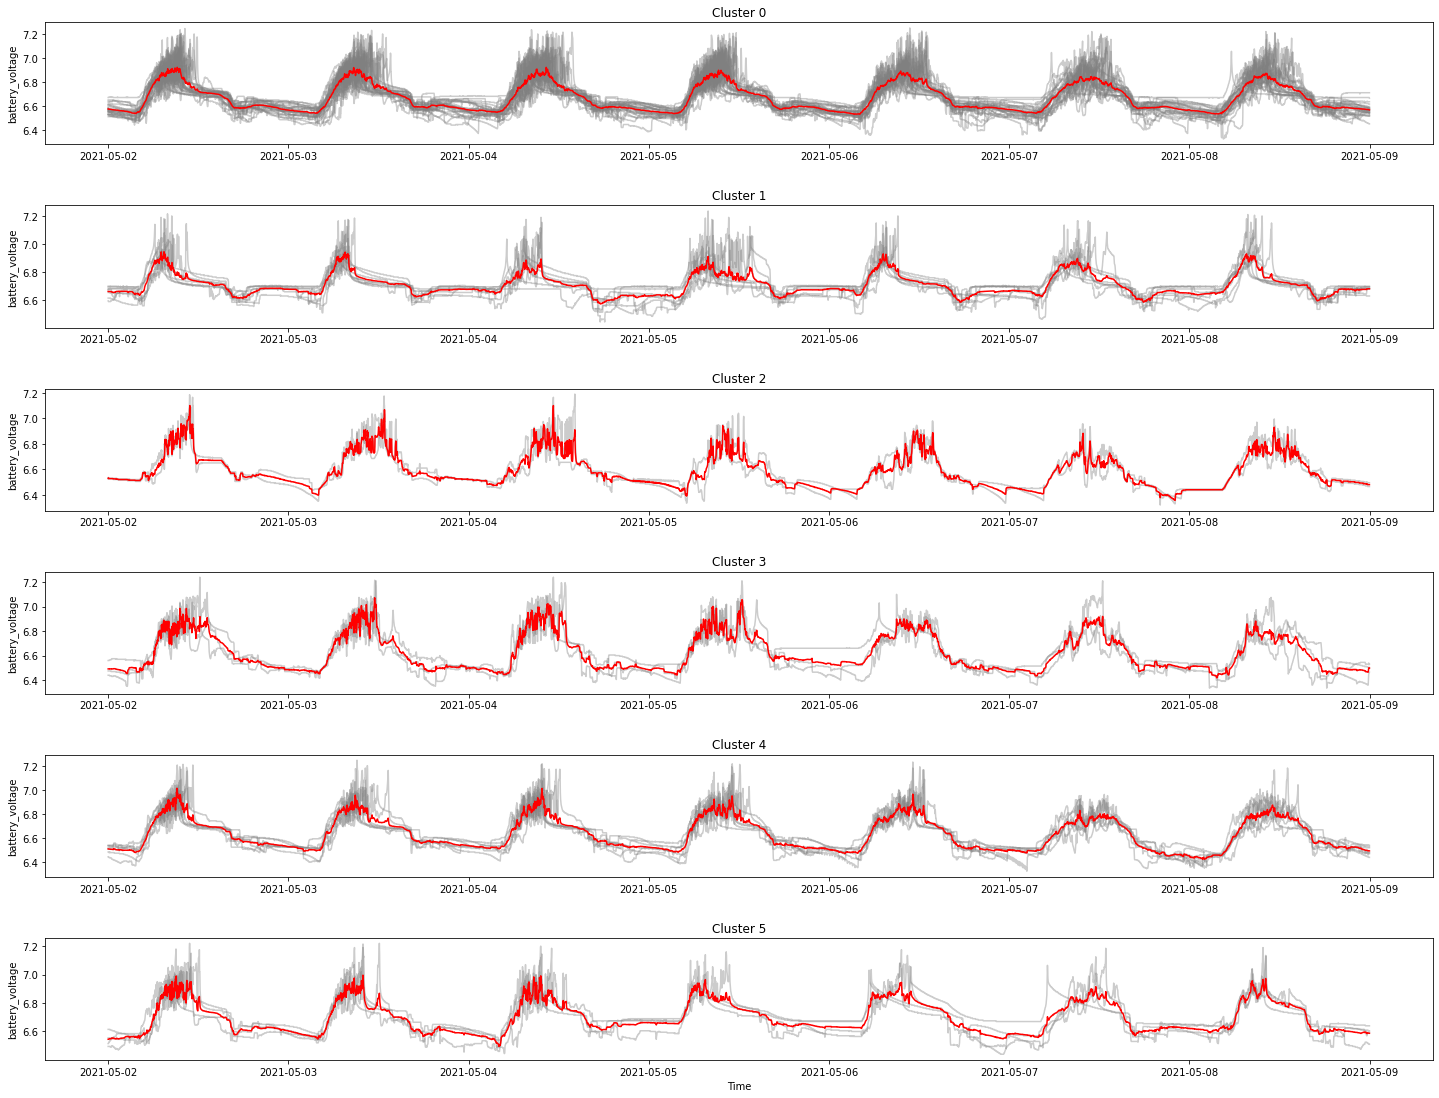

In [14]:
# Larger plots showing inline
plt.rcParams["figure.figsize"] = (20,15)

fig, axs = plt.subplots(len(set(labels)))
fig.tight_layout()

for label in set(labels):
    for i in range(len(data.battery_id.unique())):
        if(labels[i]==label):
            axs[label].set_title("Cluster {}".format(label))
            axs[label].set_ylabel(variable_to_analyse)
            axs[label].plot(bat_df[i], c="gray", alpha=0.4)
    axs[label].plot(longest_series.index, km.cluster_centers_[label], c="red")
plt.xlabel("Time")
plt.subplots_adjust(hspace=0.5)

(array([26.,  8.,  2.,  3.,  7.,  4.]),
 array([0.        , 0.83333333, 1.66666667, 2.5       , 3.33333333,
        4.16666667, 5.        ]),
 <BarContainer object of 6 artists>)

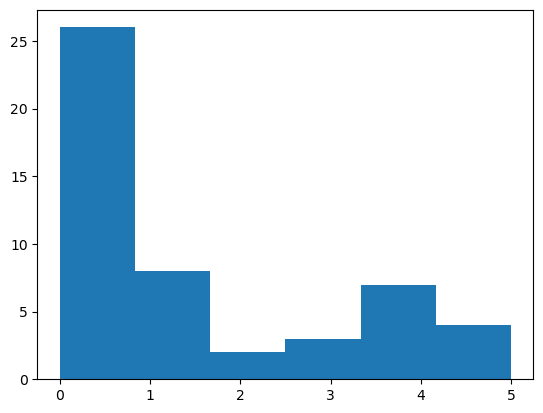

In [15]:
# Reseting stylesheet
plt.rcParams.update(plt.rcParamsDefault)

# Distribution of time series in clusters
plt.hist(labels, bins=cluster_count)